In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
import json
import requests
from github import Github

In [2]:
def toUnixTime(date, format):
    t2 = datetime.strptime(date, format)
    t1 = datetime(1970, 1, 1)
    ans = (t2 - t1).total_seconds()*1000
    ans = int(ans)
    return ans

In [3]:
sources = {}
data = {}

In [4]:
url = lambda metric: f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{metric}_global.csv' 
metrics = ['confirmed', 'recovered', 'deaths'] 
for metric in metrics: sources[metric] = url(metric)
time_series = {metric: pd.read_csv(sources[metric]) for metric in metrics}

for metric in time_series:
    df = time_series[metric]
    gb = df.groupby('Country/Region')
    df = gb.sum()
    df = df.loc[:,'1/22/20':] 
    time_series[metric] = df

metrics.append('infected')
time_series['infected'] = time_series['confirmed']-time_series['recovered']-time_series['deaths']

In [6]:
# time_series['infected'] = time_series['confirmed']-time_series['recovered']-time_series['deaths']

# for metric in time_series:
#     time_series[metric].loc['World'] = time_series[metric].sum()

# for metric in metrics:
#     time_series[f'daily_{metric}'] = time_series[metric].diff(axis=1)
#     time_series[f'7MA_daily_{metric}'] = time_series[f'daily_{metric}'].rolling(window=7, axis=1).mean()

In [7]:
sources['iso'] = 'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv'
iso_df = pd.read_csv(sources['iso'], index_col='name')
rename = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Côte d'Ivoire": "Cote d'Ivoire",
    "Iran (Islamic Republic of)": "Iran",
    "Korea, Republic of": "Korea, South",
    "Taiwan, Province of China": "Taiwan*",
    "United States of America": "US",
    "Russian Federation":"Russia",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "Moldova, Republic of": "Moldova",
    "Viet Nam": "Vietnam",
    "Tanzania, United Republic of": "Tanzania",
    "Palestine, State of": "West Bank and Gaza",
    "Syrian Arab Republic": "Syria",
    "Lao People's Democratic Republic": "Laos",
    "Myanmar":"Burma",
    "Congo, Democratic Republic of the": "Congo (Kinshasa)",
    "Congo": "Congo (Brazzaville)"
}
iso_df.rename(index=rename, inplace=True)
iso_df.loc['Kosovo'] = 'XK'
iso_df.loc['Namibia'] = 'NA'
iso_df.loc['World'] = 'WD'

In [8]:
sources['vaccines'] = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv'
df = pd.read_csv(sources['vaccines'])
replace = {'United States': 'US'}
df['location'].replace(replace, inplace=True)
df['date'] = df['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').strftime('%#m/%#d/%y')) 
vaccines_df = pd.DataFrame(index=time_series['confirmed'].index, columns=time_series['confirmed'].columns)

for country in iso_df.index:
    try:
        tmp_df = df[df['location'] == country]
        tmp_df.set_index('date', inplace=True)
        vaccines_df.loc[country] = tmp_df['total_vaccinations']
    except: continue

vaccines_df = vaccines_df.iloc[:,:-1]
vaccines_df.fillna(method='ffill', inplace=True, axis=1)
vaccines_df.fillna(value=0, inplace=True)
time_series['vaccines'] = vaccines_df

In [9]:
for metric in metrics: 
    time_series[metric].loc['World'] = time_series[metric].sum()

metrics.append("vaccines")
for metric in metrics:
    time_series[f'daily_{metric}'] = time_series[metric].diff(axis=1)
    time_series[f'7MA_daily_{metric}'] = time_series[f'daily_{metric}'].rolling(window=7, axis=1).mean()

In [10]:
general_df = pd.DataFrame(index=time_series['confirmed'].index)

for metric in metrics:
    general_df[metric] = time_series[metric].iloc[:,-1]
    general_df[f'daily_{metric}'] = time_series[f'daily_{metric}'].iloc[:,-1]

# general_df.fillna(value=0, inplace=True)
general_df = general_df.astype(int)
general_df.sort_values('confirmed', ascending=False, inplace=True) 
general_df = general_df.applymap(lambda x: '{:,}'.format(x))

In [11]:
general_df['country'] = general_df.index
general_df['iso'] = iso_df['alpha-2']
general_df['region'] = iso_df['region']
general_df['last_update'] = str(datetime.utcnow())[:-7]

In [12]:
no_match = general_df[general_df['iso'].isnull()].index
for metric in time_series:
    time_series[metric].drop(index=no_match, inplace=True)
general_df.drop(index=no_match, inplace=True)

In [13]:
class countryData:
    def __init__(self, country):
        self.general = general_df.loc[country]
        self.time_series = {metric: time_series[metric].loc[country] for metric in time_series}
        self.preProcessing()
    
    def preProcessing(self):
        def getStart(metric, atleast=1):
            s = self.time_series[metric]
            tmp_s = s[s > atleast]
            if len(tmp_s): start = tmp_s.index[0]
            else: start = s.index[0]
            if metric == '7MA_daily_confirmed' and start < '1/29/20': start = '1/29/20' 
            return start
        
        # start = getStart(metric='7MA_daily_confirmed', atleast=1000)
        start = '7/1/20'
        self.time_series = {metric: self.time_series[metric][start:] for metric in self.time_series}

        start_vaccines = getStart(metric='7MA_daily_vaccines', atleast=1000)
        self.time_series['vaccines'] = self.time_series['vaccines'][start_vaccines:]
        self.time_series['daily_vaccines'] = self.time_series['daily_vaccines'][start_vaccines:]
        self.time_series['7MA_daily_vaccines'] = self.time_series['7MA_daily_vaccines'][start_vaccines:]
        # self.time_series['starts'] = start_vaccines
        self.time_series['starts'] = {'confirmed':toUnixTime(start, format="%m/%d/%y"),'vaccines': toUnixTime(start_vaccines, format="%m/%d/%y")} 

    def to_dict(self):
        res = {
            'general': self.general.to_dict(),
            'time_series': {metric: self.time_series[metric].to_list() for metric in self.time_series if metric != 'starts'}
        }
        res['time_series']['starts'] = self.time_series['starts']
        return res

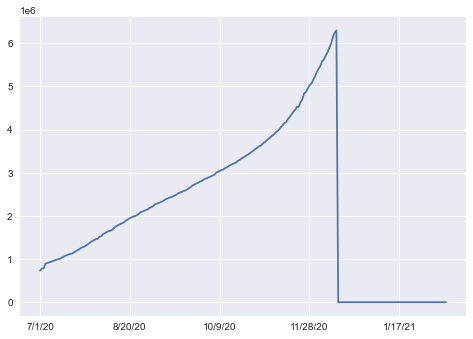

In [16]:
country_data = countryData('US')
country_data.time_series['recovered'].plot()

In [16]:
def genCountryData(country):
    data = countryData(country)
    return data.to_dict()

In [17]:
def manualUpdate():
    general_df.to_json('./data/general.json', orient='records')
    for country in general_df.index:
        country_iso = general_df.loc[country]['iso']
        res = genCountryData(country)
        with open('./data/time_series/'+country_iso+'.json', 'w') as doc: json.dump(res, doc)

In [18]:
def updateData(access_token):
    g = Github(access_token)
    repo = g.get_user().get_repo("CoronaTrack")
    
    res = general.to_json(orient='records')
    contents = repo.get_contents(f"data/general.json")
    repo.update_file(contents.path, "automatic update", res, contents.sha)
    
    for country in general_df.index:
        country_iso = general_df.loc[country]['iso']
        country_data = genCountryData(country)
        res = json.dumps(country_data)
    
        contents = repo.get_contents(f"data/time_series/{country_iso}.json")
        repo.update_file(contents.path, "automatic update", res, contents.sha)


In [19]:
manualUpdate()